In [22]:
import rasterio
from rasterio.transform import rowcol
from pyproj import Transformer

In [23]:
hennepin = rasterio.open("output2.tif")
green = rasterio.open("green.tif")


In [24]:
hennepin.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': 0.0,
 'width': 10130,
 'height': 11032,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32615"]]'),
 'transform': Affine(10.0, 0.0, 419960.0,
        0.0, -10.0, 5029750.0)}

In [25]:
h_to_wgs84 = Transformer.from_crs(hennepin.crs, "EPSG:4326", always_xy=True)
h_from_wgs84 = Transformer.from_crs("EPSG:4326", hennepin.crs, always_xy=True)

g_to_wgs84 = Transformer.from_crs(green.crs, "EPSG:4326", always_xy=True)
g_from_wgs84 = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)

In [26]:
h_band = hennepin.read(1)
g_band = green.read(1)

First we define the bounding box, which is the same bounding box of the green space band.

Now we write some code that gets a random acre inside the bounding box.

In [27]:
import numpy as np

ACRE_EDGE_METERS = 63.6149353533
DEGREES_PER_METER = 8.983e-6

In [28]:
# Very green area: (np.float32(23.872145), np.float64(8.207601746116067)) OR 3668.7333532301463
# Very red area: (np.float32(0.0), np.float64(8.36240856826096)) OR 4282.99824673542

In [29]:
def generate_point():
    lat = np.random.uniform(
        green.bounds.bottom + ACRE_EDGE_METERS * DEGREES_PER_METER, 
        green.bounds.top
    )

    lon = np.random.uniform(
        green.bounds.left, 
        green.bounds.right - ACRE_EDGE_METERS * DEGREES_PER_METER
    )
    return lat, lon

def generate_window(region, from_wsg84, lon, lat):
    x, y = from_wsg84.transform(lon, lat)
    row_min, col_min = rowcol(region.transform, x, y)

    # Bottom right for green
    x, y = from_wsg84.transform(lon + ACRE_EDGE_METERS * DEGREES_PER_METER, lat - ACRE_EDGE_METERS * DEGREES_PER_METER)
    row_max, col_max = rowcol(region.transform, x, y)
    window = Window(col_off=col_min, row_off=row_min, width=col_max-col_min+1, height=row_max-row_min+1)

    return window

In [30]:
data = {
    "heat": [],
    "green": []
}

for i in range(5000):
    
    # Generate random coordinates
    lat, lon = generate_point()

    # Get windows
    green_window = generate_window(green, g_from_wgs84, lon, lat)
    heat_window = generate_window(hennepin, h_from_wgs84, lon, lat)

    green_data = green.read(1, window=green_window)
    heat_data = hennepin.read(1, window=heat_window)

    if not np.all(green_data.sum()) or not np.isfinite(heat_data.sum()):
        continue

    data["heat"].append(heat_data.sum())
    data["green"].append(green_data.sum())

In [31]:
import pandas as pd

df = pd.DataFrame(data)

In [32]:
df.max() - df.min()

heat     4915.061448
green      31.067452
dtype: float64

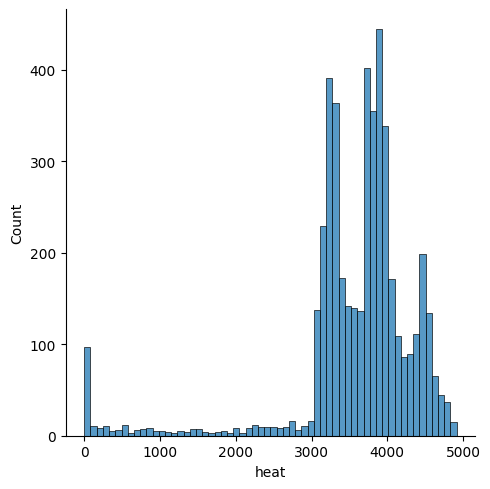

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data=df, x='heat')

In [34]:
# infile = "output.tif"
# outfile = "output2.tif"
# new_nodata = 0.0  # Or 0, or np.nan depending on your workflow

# with rasterio.open(infile) as src:
#     profile = src.profile.copy()
#     data = src.read(1)  # first band

#     # Replace nodata values
#     nodata = src.nodata
#     data[data == nodata] = new_nodata

#     # Update profile
#     profile.update(nodata=new_nodata)

#     # Write out new file
#     with rasterio.open(outfile, "w", **profile) as dst:
#         dst.write(data, 1)